<a href="https://colab.research.google.com/github/Mahi200728/DataScience-A2/blob/main/Javi_MaheU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context



In this project I am trying to figure out the amount of bills that were introduced to the senate and got a vote.

This is super important because bills are the way we propose new laws or changes to already existing laws and the lack of voting causes our system to be much slower. To better understand this system I wanted to see how many bills proposed were voted on. This is really important because it shows us an insight into the effiency of our country. Lack of efficeny is a huge issue when looking at world politics and our countries stance in the world since a delay in our poltical sphere can negativly affect our standing in global politics as well as global economics.

# Posterior Predictive Graphs aka The Code

In [1]:
# importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [3]:
#URL link that connects to the raw data within Github
url_2324 = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
data_2324 = pd.read_csv(url_2324)

# We want to be able to group by position in the future, so make Pos a category
data = pd.read_csv(url_2324,dtype={'Pos':'category'})

# Since there is so much data I am going to isolate the parts we actually only need
data = data[['Player','Pos', 'TRB',]]
data

,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


In [4]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = data.Pos.cat.codes.values

#an array of the strings that represent positions
pos_codes = data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bask_coords = {"pos": pos_codes}

So pos_idx helps show our liklihood of which player plays which position so we can then implememt a prior for each of the positions. The pos_codes helps us represent each position and helps the code reference those different possitions.

<Axes: ylabel='TRB'>

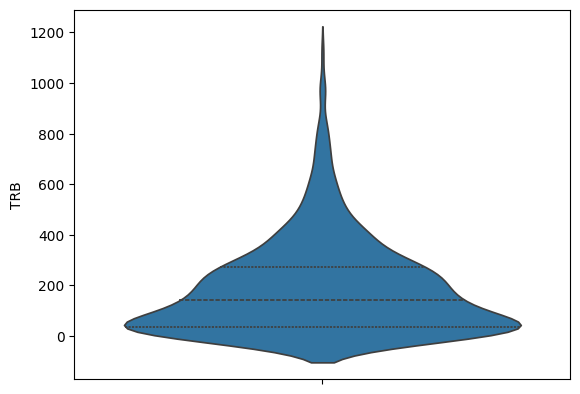

In [5]:
# visualizing data
sns.violinplot(data.TRB,inner='quart')

After running the violin plot we can see how there is a huge frequency of data points near 0-200 meaning the data is very right skewed. Now because of the obvious skewness we can automatically not consider the normal distribution because it isn't made to handle this amount of skewness. That being said I don't think the usual plots we use for skewness is valid either. I say this mainly because Exponetial doesn't really help with overdispersion which is a huge issue with this data (the data gies from like -100 to 1200). For skewnormal there were a few reasons, mainly the fact that skew normal usually handles continuous data (which this is not) and it also doesn't really address over dispersion, also there just is a lot of places for error because you have to decide on the scale and shape (there is probabaly a mathamatical reasoning behind choosing those values but I honestly just don't know it). All of that being said, based on what we have learned so far I think Exponetial is still the best model for the data because if we just mess with the hyperpriors a bit I think we can match up the data with the ppc.

In [47]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = .5, beta = 1)
    b = pm.Gamma('b', alpha = .5, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential
    _ = pm.Exponential('trb', lam = λ, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

So I went ahead and started to decrease the alpha priors because that is the variable that controls the peaks and overall shape of the distribution. But as I got smaller and smaller I kept on getting divergences so I decided to just leave it .5. If I were to have a way to mathamatically pick a number for alpha I think it would have helped or just a different model overall. I also didn't mess with the beta because my obsereved data basically fit the scale and spread of the posterior predictive so I left it as it is.

Output()

(0.0, 1100.0)

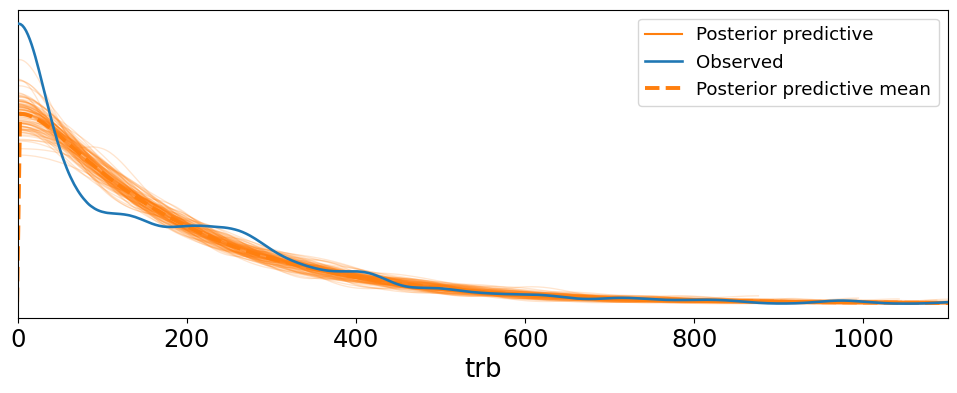

In [46]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

Obviously there is a bit of a peak at 0 but this is still better than I was expecting. Again if I had exact values for my alphas I think it would have helped fit the peak more into the graph itself.

Now I decided to split the players up by positions to be able to change the priors of all of them seperately but still have one big hyperprior over all of them together. This helps me break down teh data more and understand each position more (they definetly would affect because some posistions just don't deal with rebounds and so if they did on the off chance that would have messed with the data, or just ingeneral their lack of rebounds definetly would have affected the TRB percentage).

In [49]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")

    #skewnormal
    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

(0.0, 0.015)

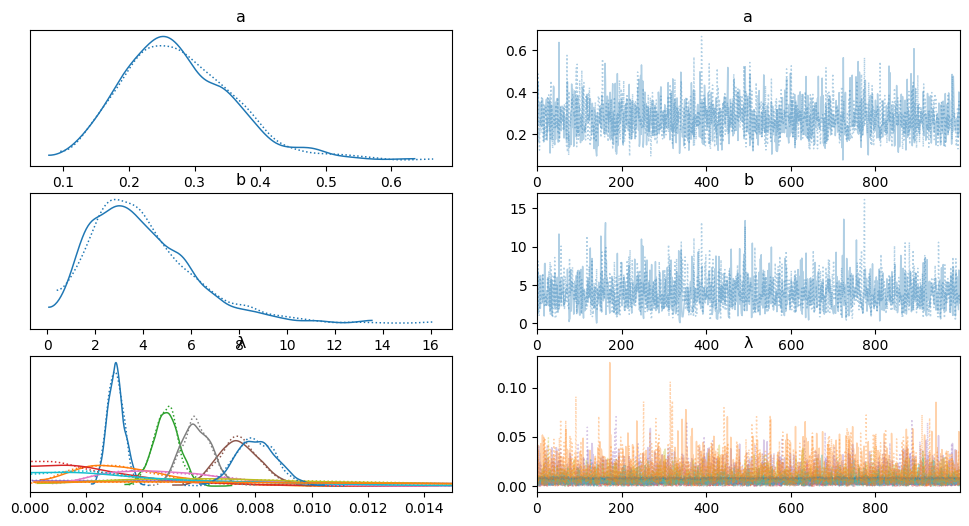

In [50]:
#az.plot_trace(idata_bask) but limiting the graph of the λ so it is easier to read
az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

Now each position is shown and you can clearly see the affect of each position when looking at the lam graph where there are some with huge peaks and others with very platued out lines.

In [32]:
az.rhat(idata_bask)

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.0
    b        float64 8B 0.9995
    λ        (pos) float64 96B 1.002 1.003 1.0 0.9997 ... 1.0 0.9993 0.9998 1.0

The rhat is super super close to 1 meaning that our rhat is ideal which is amazing.

array([<Axes: >], dtype=object)

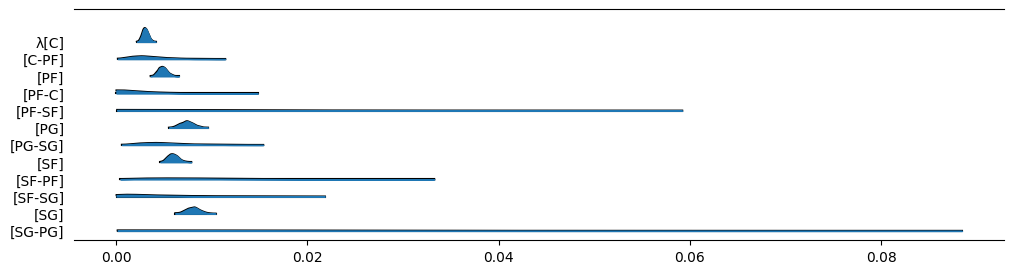

In [34]:
az.plot_forest(idata_bask, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The plot forest really helps us visualize the differences between each position and why it is so important to seperate the data more to better understand it. Positions like SG-PG have a huge range compared to PF which makes sense and so when doing stuff with this data we need to take that into account.

In [35]:
#retrieving the array of means

posterior = idata_bask.posterior
lambda_variable = posterior['λ']
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values

#print(mean_array)

#creating the array of reciprocals

reciprocal_array = []
for value in mean_array:
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)

#print (reciprocal_array)

# go through each of the positions and print it next to the 1/lamda
# print(pos_codes)
for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 327.82264810085405
C-PF: 294.15506052915873
PF: 205.28849148126358
PF-C: 372.1543376298041
PF-SF: 88.87901014333684
PG: 134.84593450082835
PG-SG: 198.30505765304406
SF: 168.05168712562653
SF-PF: 114.25573165762633
SF-SG: 214.17194119712858
SG: 124.39590297175502
SG-PG: 62.81852853228834


Here we took the recipricol of the data which is super important becyase it helps us get the actual prediction. And based on the bar graph you can see how much nicer this is than the plot forest and also we are able to just better understand the data after taking the recipricol.

<BarContainer object of 12 artists>

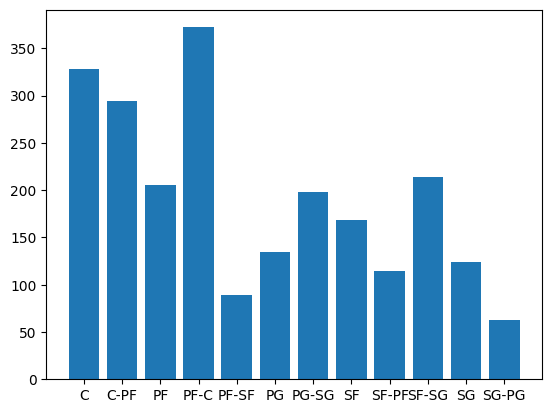

In [36]:
plt.bar(pos_codes, reciprocal_array)

## Conclusion

As I said above certain positions are just more likely to get a rebound than others (like center and power forward) meaning that they will have higher predictive values (backed up by the graph) while other positions like shooting guard and point guard are less likely to just because of their position (also backed up by the graph). Based on my understand of basketball and the graphs I think we were able to get a well working model and diverge the data to better understand the intricite detials!